Пришлось "освежить" самый первый ноутбук для этого случая, потому что больше не удалось запустить обучение на colab до донца. В нем выбраны не самые удачные параметры (lr и tf), но это лучше, чем модель, которая только пару тысяч батчей успела пройти во время обучения...

# Предобработка данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!wget http://shannon.cs.illinois.edu/DenotationGraph/data/flickr30k-images.tar

--2020-02-23 10:11:10--  http://shannon.cs.illinois.edu/DenotationGraph/data/flickr30k-images.tar
Resolving shannon.cs.illinois.edu (shannon.cs.illinois.edu)... 18.220.149.166
Connecting to shannon.cs.illinois.edu (shannon.cs.illinois.edu)|18.220.149.166|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4440780800 (4.1G) [application/x-tar]
Saving to: ‘flickr30k-images.tar’

flickr30k-images.ta 100%[===================>]   4.14G  25.5MB/s    in 81s     

2020-02-23 10:12:31 (52.5 MB/s) - ‘flickr30k-images.tar’ saved [4440780800/4440780800]



In [3]:
%%time
!tar -xf '/content/flickr30k-images.tar'

CPU times: user 543 ms, sys: 69 ms, total: 612 ms
Wall time: 1min 52s


In [0]:
from torchvision import transforms, datasets
import os
import torch, torch.nn as nn
import torch.nn.functional as F
from torchvision.models.inception import Inception3
from torch.utils.model_zoo import load_url
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import random

In [0]:
image_dir = '/content/flickr30k-images' 

## Подготовка captions

In [0]:
results = pd.read_csv("/content/drive/My Drive/Image Captioning/Flickr30/results_new.csv", sep='|', index_col=None)

In [7]:
results.head(15)

image_name  ...                                            comment
0   1000092795.jpg  ...   Two young guys with shaggy hair look at their...
1   1000092795.jpg  ...   Two young , White males are outside near many...
2   1000092795.jpg  ...   Two men in green shirts are standing in a yard .
3   1000092795.jpg  ...       A man in a blue shirt standing in a garden .
4   1000092795.jpg  ...            Two friends enjoy time spent together .
5     10002456.jpg  ...   Several men in hard hats are operating a gian...
6     10002456.jpg  ...   Workers look down from up above on a piece of...
7     10002456.jpg  ...   Two men working on a machine wearing hard hats .
8     10002456.jpg  ...              Four men on top of a tall structure .
9     10002456.jpg  ...                         Three men on a large rig .
10  1000268201.jpg  ...   A child in a pink dress is climbing up a set ...
11  1000268201.jpg  ...   A little girl in a pink dress going into a wo...
12  1000268201.jpg  ...   A little girl climbing the stairs to her play...
13  1000268201.jpg  ...    A little girl climbing into a wooden playhouse 
14  1000268201.jpg  ...              A girl going into a wooden building .

[15 rows x 3 columns]

In [0]:
# Переименуем колонки, чтобы убрать пробелы в начале имени
results.columns = ['image_name', 'comment_number', 'comment']

In [0]:
# Приведем строки к нижнему регистру
results.comment = results.comment.str.lower()

In [0]:
results = results.groupby('image_name')['comment'].apply(list).reset_index(name='captions')

In [11]:
results

image_name                                           captions
0      1000092795.jpg  [ two young guys with shaggy hair look at thei...
1        10002456.jpg  [ several men in hard hats are operating a gia...
2      1000268201.jpg  [ a child in a pink dress is climbing up a set...
3      1000344755.jpg  [ someone in a blue shirt and hat is standing ...
4      1000366164.jpg  [ two men , one in a gray shirt , one in a bla...
...               ...                                                ...
31778   997338199.jpg  [ woman writing on a pad in room with gold , d...
31779   997722733.jpg  [ a person in a red shirt climbing up a rock f...
31780   997876722.jpg  [ two male construction workers are working on...
31781    99804383.jpg  [ an older busker in glasses plays an eastern ...
31782   998845445.jpg  [ a man in shorts and a hawaiian shirt leans o...

[31783 rows x 2 columns]

In [12]:
results.image_name[0]

'1000092795.jpg'

In [13]:
results.captions[0]

[' two young guys with shaggy hair look at their hands while hanging out in the yard .',
 ' two young , white males are outside near many bushes .',
 ' two men in green shirts are standing in a yard .',
 ' a man in a blue shirt standing in a garden .',
 ' two friends enjoy time spent together .']

In [14]:
len(results)

31783

In [0]:
seed = 42

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(results, test_size=1024)

In [0]:
val_set.index = range(len(val_set))

In [18]:
val_set

image_name                                           captions
0     3655176735.jpg  [ an older woman appears to read from a childr...
1     7669392800.jpg  [ numerous bicyclists wearing bicyclist appare...
2     4546029322.jpg  [ in this picture we see multiple people cross...
3      120764850.jpg  [ a baby on the floor laughing at an older ano...
4     2912210904.jpg  [ a man loads trees onto a cart on the side of...
...              ...                                                ...
1019  6813684611.jpg  [ three people are playing music ; two with vi...
1020  3288203502.jpg  [ redheaded woman holding clear plastic over p...
1021  6221289833.jpg  [ a boy wearing a white and green athletic uni...
1022   241345323.jpg  [ sooners football player number 50 plays in a...
1023  5392145976.jpg  [ a woman rollerblader with knee and elbow pad...

[1024 rows x 2 columns]

In [0]:
train_set.index = range(len(train_set))

In [20]:
train_set

image_name                                           captions
0      2251277216.jpg  [ various people are walking along a path towa...
1       263216826.jpg  [ a man and a woman in an orange shirt are sit...
2      3627929314.jpg  [ a little boy sitting on the ground looking u...
3      3019986034.jpg  [ a woman in a plaid skirt is playing a violin...
4      4508999124.jpg  [ a small boy with a blue and yellow backpack ...
...               ...                                                ...
30754  7108301125.jpg  [ several women are playing some sort of sport...
30755  2380519648.jpg  [ a man with a cap and not wearing shirt is la...
30756   128396207.jpg  [ a bike rider with khaki green shorts , a blu...
30757   361831875.jpg  [ a person in a green coat looks upwards while...
30758  4806000438.jpg  [ men wearing red and white stripe shirts and ...

[30759 rows x 2 columns]

In [0]:
from collections import Counter
token_counts = Counter()

for cap in train_set.captions:
    for line in cap:
        token_counts.update(line.split())

In [22]:
token_counts.most_common(10)

[('a', 263031),
 ('.', 146139),
 ('in', 80901),
 ('the', 61002),
 ('on', 44158),
 ('and', 42866),
 ('man', 41190),
 ('is', 39806),
 ('of', 37532),
 ('with', 35041)]

Pretrained Embeddings

In [23]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip 

--2020-02-23 10:14:41--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  28.5MB/s    in 52s     

2020-02-23 10:15:34 (27.8 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [24]:
!unzip '/content/crawl-300d-2M.vec.zip' 

Archive:  /content/crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [0]:
import gensim

In [26]:
%%time
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(fname='/content/crawl-300d-2M.vec', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 9min 24s, sys: 7.93 s, total: 9min 32s
Wall time: 9min 28s


In [0]:
min_count = 5
tokens = [token for token, num in token_counts.items() if (token in w2v_model and num>=min_count)]

In [0]:
UNK, PAD, BOS, EOS = "UNK", "PAD", "<bos>", "<eos>"
tokens = [PAD, BOS, EOS, UNK] + tokens

In [29]:
len(tokens)

7628

In [0]:
n_tokens = len(tokens)

In [0]:
token_to_id = {t:i for i, t in enumerate(tokens)}

In [0]:
UNK_IDX, PAD_IDX = token_to_id["UNK"], token_to_id["PAD"]
BOS_IDX, EOS_IDX = token_to_id["<bos>"], token_to_id["<eos>"]

In [33]:
numpy_embeddings = np.zeros(shape=[len(tokens), 300],dtype=np.float32)

for word in tokens:
    if word in w2v_model:
        vector = w2v_model.get_vector(word)
        index  = token_to_id[word]
        numpy_embeddings[index] = vector
        
pretrained_embeddings = torch.FloatTensor(numpy_embeddings)
pretrained_embeddings.shape

torch.Size([7628, 300])

## Train dataset

In [0]:
def as_matrix(sequences, max_len=None):
    """ 
    Convert a list of tokens into a matrix with padding 
    params:
        sequences: list of sentences. Each sentence is a tokenized string or list of tokens
        max_len: if specified, 
    """

    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
   
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len+2), np.int32(PAD_IDX))
    for i,seq in enumerate(sequences):
        row_ix = [BOS_IDX] + [token_to_id.get(word, UNK_IDX) for word in seq[:max_len]] + [EOS_IDX]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [0]:
# batch generator
from random import choice

def generate_batch(dataset, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_index = np.random.randint(0, len(dataset), size=batch_size)
    
    batch_images, batch_captions = [], []

    for ind in random_index:

        image, captions = dataset[ind]

        batch_images.append(image)
        
        # pick one from a set of captions for each image
        caption = choice(captions)

        batch_captions.append(caption)

    batch_captions = as_matrix(batch_captions, max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions, dtype=torch.int64)
    

In [0]:
class FlickrDataset(Dataset):
    """Flickr30 dataset."""

    def __init__(self, data_frame, root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = data_frame 
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        
        image_name = os.path.join(self.root_dir,
                                self.data_frame.image_name[idx])
        image = plt.imread(image_name)
        image = np.array(Image.fromarray(image).resize((299, 299))).astype('float32') / 255.
        image = image.transpose([2, 0, 1])

        captions = self.data_frame.captions[idx]

        return image, captions

    def show_sample(self, idx):

        image_name = os.path.join(self.root_dir,
                                self.data_frame.image_name[idx])
        image = plt.imread(image_name)
        image = np.array(Image.fromarray(image).resize((299, 299))).astype('float32') / 255.

        captions = self.data_frame.captions[idx]
        captions = np.array(captions)

        plt.imshow(image)
        print(captions)

In [0]:
train_dataset = FlickrDataset(train_set, image_dir)

In [38]:
len(train_dataset)

30759

[' various people are walking along a path towards a fenced-in area that is surrounded by small buildings .'
 ' people running on a sidewalk in the middle of a grassy area .'
 ' people running and walking in and out of a small farm town .'
 ' several couples running down the road to a farm house .'
 ' a woman runs along the sidewalk .']


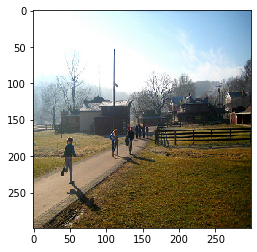

In [0]:
train_dataset.show_sample(0)

[' crowded street with a man holding a subway sign pointing customers to a subway sandwich shop .'
 ' a man dressed in blue , holding a subway sandwich sign on the sidewalk .'
 ' a man in a blue shirt and blue jeans standing behind a subway sign .'
 ' a man in all bright blue against a subway sign in new york city .'
 ' man holding a sign promoting subway restaurant .']


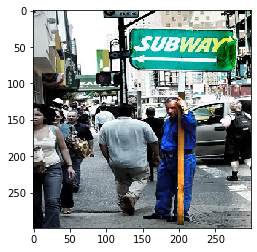

In [0]:
train_dataset.show_sample(12345)

Протестируем генерацию батча:

In [0]:
# max_caption_len без учета спец символов для начала и конца предложения
batch = generate_batch(train_dataset, 3, max_caption_len=10)

In [0]:
batch[1]

tensor([[   1,    9,  412,    5,   45,   35,   29, 1611,   22,    9,  409,    2],
        [   1,  180,   15,   42,  515,  421,   56,  422,   27, 1201,  208,    2],
        [   1,   25,  249,   15,   87, 2255, 2857,   56,  619,  106,   24,    2]])

In [0]:
batch[0].shape, batch[1].shape

(torch.Size([3, 3, 299, 299]), torch.Size([3, 12]))

In [0]:
batch = generate_batch(train_dataset, 3)

In [0]:
batch[1]

tensor([[   1,    9,   63,  122,   98,    9, 4665,  137,  251,   30,  208,   25,
           91,   63,  122,   37,  807,   20,    2,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    9,   41,   24,    9,  139,  110,   48, 4945,   76,   48,   25,
          303,  203,    9,  155,   27,  133, 1525,   20,    2,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   61,  108,   68,   87,  100,  170,   56,    9,   94,  111,   29,
           94,   29,  520,  116,   87,    9, 3843,  112,   25,   91,   74,    9,
         2489,   29,    9, 7556, 1645,   44,   87,    9, 2447,   20,    2]])

In [0]:
batch[0].shape, batch[1].shape

(torch.Size([3, 3, 299, 299]), torch.Size([3, 35]))

## Validation dataset

In [0]:
# Переводит массив индексов в строку/массив с токенами (до первого символа конца строки)
def translate(list_ind, to_str=True):
  
  if EOS_IDX in list_ind:
    max_ind = list_ind.index(EOS_IDX)
  else:
    max_ind = len(list_ind)

  if to_str:
    return (' ').join([tokens[ind] for ind in list_ind[:max_ind]])
  else:
    return [tokens[ind] for ind in list_ind[:max_ind]]

In [0]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

In [0]:
val_dataset = FlickrDataset(val_set, image_dir)

In [42]:
len(val_dataset)

1024

[' swimming instructors teaching young girls how to float in a pool .'
 ' man in black swimsuit plays in pool with three young children .'
 ' two men in wetsuits supervise children as they learn to swim .'
 ' swimming instructors show young girls how to float .'
 ' a group of children learning to swim .']


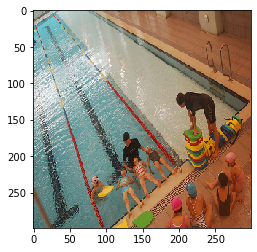

In [43]:
# Fixed example
val_dataset.show_sample(992)

In [0]:
batch_size_val = 32

In [0]:
val_size = len(val_dataset) // batch_size_val * batch_size_val

In [46]:
val_size

1024

In [0]:
# Для расчета bleu
references = []
for cap in val_set.captions[:val_size]:
  new_cap = []
  for str_cap in cap:
    new_cap.append(list(str_cap.split()))
  references.append(new_cap)

In [48]:
references[0]

[['an',
  'older',
  'woman',
  'appears',
  'to',
  'read',
  'from',
  'a',
  'children',
  "'s",
  'book',
  'in',
  'an',
  'indoor',
  'setting',
  ',',
  'while',
  'a',
  'seated',
  'gentleman',
  'in',
  'a',
  'service',
  'uniform',
  'looks',
  'on',
  '.'],
 ['a',
  'woman',
  'with',
  'short',
  'black',
  'hair',
  'and',
  'a',
  'colorful',
  'necklace',
  'reads',
  'a',
  'children',
  "'s",
  'illustration',
  'book',
  '.'],
 ['a',
  'woman',
  'with',
  'a',
  'white',
  'shirt',
  'holding',
  'a',
  'children',
  'book',
  '.'],
 ['a', 'woman', 'reading', 'a', 'children', "'s", 'book', '.'],
 ['a', 'lady', 'reading', 'a', 'story', 'book', '.']]

In [0]:
# batch generator
def generate_batch_val(dataset, indx, batch_size, max_caption_len=None):
    
    batch_images, batch_captions = [], []

    for ind in range(indx, indx+batch_size):

        image, captions = dataset[ind]

        batch_images.append(image)
        
        # pick one from a set of captions for each image
        caption = choice(captions)

        batch_captions.append(caption)

    batch_captions = as_matrix(batch_captions, max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions, dtype=torch.int64)   

In [0]:
def evaluate(model, criterion, max_len=None, val_size=len(val_dataset), batch_size=batch_size_val):
    
    model.eval()
    
    epoch_loss = 0
    bleu = 0
    hypotheses = []

    # Не учитываем последний неполный батч
    val_size = val_size // batch_size * batch_size

    random_ind = random.randint(0, val_size-1)
    
    with torch.no_grad():
    
        for i in range(0, val_size, batch_size):

            image_vectors, captions_ix = generate_batch_val(val_dataset, i, batch_size) 
            
            image_vectors, captions_ix = image_vectors.to(device), captions_ix.to(device)

            captions_ix_next = captions_ix[:, 1:].contiguous()
        
            outputs, atts = network(image_vectors, captions_ix, teacher_forcing_ratio=0.)

            loss = criterion(outputs.contiguous().view(-1, outputs.shape[-1]), captions_ix_next.view(-1))
            
            epoch_loss += loss.item()

            outputs_max = outputs.argmax(-1)
            for out in outputs_max:
              hypotheses.append(translate(out.tolist(), to_str=False))

            if random_ind in range(i,i+batch_size):
              print('Random example:')
              print('\tTarget: {}'.format(translate(captions_ix_next[random_ind % batch_size].tolist())))
              print('\tOutput: {}'.format(translate(outputs.argmax(-1)[random_ind % batch_size].tolist())))

    print('Fixed example :')
    print('\tTarget: {}'.format(translate(captions_ix_next[0].tolist())))
    print('\tOutput: {}'.format(translate(outputs.argmax(-1)[0].tolist())))

    bleu = corpus_bleu(references, hypotheses)
        
    return epoch_loss / (val_size // batch_size), bleu*100

#Network

##Encoder

In [0]:
class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: warn("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048

        return x_for_attn, x_for_capt 

In [0]:
def beheaded_inception_v3(transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    inception_url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
    model.load_state_dict(load_url(inception_url))
    return model

In [53]:
%%time
inception = beheaded_inception_v3().train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth



CPU times: user 4min 21s, sys: 1.94 s, total: 4min 23s
Wall time: 4min 23s


##Decoder + Attention

In [0]:
class Attention(nn.Module):
    def __init__(self, cnn_feature_size, hid_dim, method="method_1"): 
        
        super(Attention, self).__init__()
        self.method = method
        self.hid_dim = hid_dim
        self.cnn_feature_size = cnn_feature_size

        self.fc_1 = nn.Linear(self.cnn_feature_size, self.hid_dim)
        self.fc_2 = nn.Linear(self.hid_dim, self.hid_dim)
        self.fc_3 = nn.Linear(self.hid_dim, 1)
       
    def forward(self, encoder_output, output, seq_len=None):

        # INPUT
        # encoder_output : (batch_size x max_len x hidden_dim) (batch_size x max_len x cnn_feature_size)
        # output : (1 x batch_size x hidden_dim) (batch_size x 1 x hidden_dim)
        #
        # OUTPUT
        # x : (batch_size x max_len)

        # (batch_size x max_len x cnn_feature_size) -> (batch_size x max_len x hidden_dim)
        x = self.fc_1(encoder_output)
        # (batch_size x hidden_dim) -> (batch_size x 1 x hidden_dim)
        y = self.fc_2(output).unsqueeze(1)

        # (batch_size x max_len x hidden_dim) + (batch_size x 1 x hidden_dim) = (batch_size x max_len x hidden_dim) -> (batch_size x max_len)
        att_weight = F.softmax(self.fc_3(torch.relu(x + y)).squeeze(2), dim=-1)
        # (batch_size x max_len x cnn_feature_size) * (batch_size x max_len x 1) -> (batch_size x cnn_feature_size)
        att = (encoder_output * att_weight.unsqueeze(2)).sum(dim=1)

        return att, att_weight

In [0]:
class Decoder(nn.Module):
    def __init__(self, attention, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048, num_layers=1):
        super(self.__class__, self).__init__()
        
        self.n_tokens = n_tokens
        self.attention = attention

        self.fc_1 = nn.Linear(lstm_units, cnn_feature_size)

        # create embedding for input words
        self.embed = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True, padding_idx=PAD_IDX) 
        self.drop = nn.Dropout(0.4) 
            
        # lstm
        self.lstm = nn.LSTMCell(emb_size + cnn_feature_size, lstm_units, bias=True) 

        self.drop_2 = nn.Dropout(0.1)

        # линейный слой для получения логитов
        self.fc_2 = nn.Linear(lstm_units, n_tokens)

        self.init_weights()
        
    def forward(self, captions, encoder_outputs, hidden=None, cell=None, teacher_forcing_ratio=1.):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]
        """

        # (batch_size)
        captions = captions 
        
        # embedded : (batch_size x emb_dim)
        embedded = self.embed(captions) 
        embedded = self.drop(embedded)

        # (batch_size x cnn_feature_size), (batch_size x max_len)
        att, att_weigths = self.attention(encoder_outputs, hidden)
        # (batch_size x hidden_dim) -> (batch_size x cnn_feature_size)
        gate = torch.sigmoid(self.fc_1(hidden))
        # (batch_size x cnn_feature_size)
        att = gate * att

        # (batch_size x (emb_dim + cnn_feature_size))
        lstm_in = torch.cat([embedded, att], dim=1)
        # hidden : (batch_size x hidden_dim)        
        hidden, cell = self.lstm(lstm_in, (hidden, cell))

        # (batch_size x n_tokens)
        prediction = self.fc_2(self.drop_2(hidden)) 

        # Дополнительно будем возвращать attention
        return prediction, hidden, cell, att_weigths

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.fc_2.bias.data.fill_(0)
        self.fc_2.weight.data.uniform_(-0.1, 0.1)

##Model

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, encoder, decoder, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048, num_layers=1):
        super(self.__class__, self).__init__()
        
        self.n_tokens = n_tokens
        self.cnn_feature_size = cnn_feature_size

        # два линейных слоя, которые будут из векторов, полученных на выходе Inseption, 
        # получать начальные состояния h0 и c0 LSTM-ки, которую мы потом будем 
        # разворачивать во времени и генерить ею текст
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, image_vectors, captions_ix=None, teacher_forcing_ratio=1.):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]
        """
        batch_size = image_vectors.shape[0] 

        image_att, image_emb = self.encoder(image_vectors)

        image_att = image_att.permute(0, 2, 3, 1).view(batch_size, -1, self.cnn_feature_size)
        num_pixels = image_att.shape[1]

        if captions_ix is None:
          max_len = 30
        else:
          max_len = captions_ix.shape[1]       
        
        #tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, self.n_tokens).to(device)
        attentions = torch.zeros(batch_size, max_len, num_pixels).to(device)


        cell = torch.sigmoid(self.cnn_to_c0(image_emb)) 
        hidden = torch.sigmoid(self.cnn_to_h0(image_emb))  
        
        # first input to the decoder is the <bos> tokens
        captions_input = torch.full((batch_size,), np.int32(BOS_IDX), dtype=torch.int64).to(device) 
        
        for t in range(1, max_len):

            lstm_outputs, hidden, cell, att = self.decoder(captions_input, image_att, hidden, cell)

            outputs[:, t, :] = lstm_outputs
            attentions[:, t, :] = att

            teacher_force = random.random() < teacher_forcing_ratio

            if teacher_force:
              captions_input = captions_ix[:, t] 
            else:
              captions_input = lstm_outputs.argmax(-1) 
        
        return outputs[:, 1:], attentions[:, 1:]
        
    def sample(self, image_vectors, max_len=None, sample=True, st=1):
        
        if max_len is None:
            max_len = 35

        batch_size = image_vectors.shape[0]

        # Генерируем подпись для одного изображения
        assert batch_size == 1

        image_att, image_emb = self.encoder(image_vectors)

        image_att = image_att.permute(0, 2, 3, 1).view(batch_size, -1, self.cnn_feature_size)
        num_pixels = image_att.shape[1]      
        
        # tensor to store decoder outputs
        sentence = []
        attentions = np.zeros((max_len, num_pixels)) 

        # Инициализируем h и c для слоя lstm
        cell = torch.sigmoid(self.cnn_to_c0(image_emb)) 
        hidden = torch.sigmoid(self.cnn_to_h0(image_emb))  
        
        # Первый раз на вход декодеру подаем символ начала строки <bos>
        captions_input = torch.full((batch_size,), np.int32(BOS_IDX), dtype=torch.int64).to(device)  
        
        for t in range(1, max_len):

            lstm_outputs, hidden, cell, att = self.decoder(captions_input, image_att, hidden, cell)

            attentions[t, :] = att.squeeze(0).data.cpu().numpy() 

            if sample:
                # Выбираем токен согласно полученному распределению вероятностей
                next_word_probs = F.softmax(lstm_outputs[0], dim=-1).data.cpu().numpy()
                next_word_probs = next_word_probs ** st / np.sum(next_word_probs ** st)
                next_word = np.random.choice(tokens, p=next_word_probs)
            else:
                # Берем токен с максимальной вероятностью
                next_word = tokens[lstm_outputs[0].data.cpu().numpy().argmax(-1)]

            if next_word == EOS:
                break

            sentence.append(next_word)

            captions_input[0] = token_to_id[next_word]
        
        return (' ').join(sentence), attentions[1:]        

# Training

In [0]:
for p in inception.parameters(): 
    p.requires_grad = False

In [58]:
pytorch_total_params = sum(p.numel() for p in inception.parameters())
pytorch_total_params

27161264

In [59]:
pytorch_total_params = sum(p.numel() for p in inception.parameters() if p.requires_grad)
pytorch_total_params

0

In [0]:
att_nn = Attention(2048, 512)
dec_nn = Decoder(att_nn, n_tokens, 300, 512, 2048, 1)
network = CaptionNet(inception, dec_nn, n_tokens, 300, 512, 2048, 1)

In [0]:
optimizer = torch.optim.Adam(network.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
network = network.to(device)

In [0]:
max_epochs = 20000
batch_size = 32
every_epochs = 1000
clip = 1

In [0]:
pytorch_total_params = sum(p.numel() for p in network.parameters() if p.requires_grad)

In [0]:
pytorch_total_params

14235597

In [0]:
pytorch_total_params = sum(p.numel() for p in network.parameters())

In [0]:
pytorch_total_params

43685261

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 1000
Train example :
	Target: a golden haired dog with wet hair is licking its nose while moving through shallow water .
	Output: a dog dog dog is a water is running a a . a . the .
Random example:
	Target: a baby on the floor laughing at an older another child .
	Output: a young boy in a blue shirt is sitting on a table .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man is jumping off a a .
Train loss    : 4.324381152629853
Val loss      : 5.674767255783081
Val bleur     : 12.373008698940465



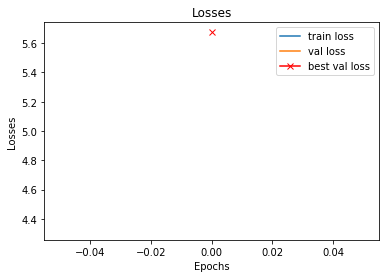

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 2000
Train example :
	Target: cowboy at a rodeo UNK his lasso at a young bull .
	Output: a greyhound a rodeo in .
Random example:
	Target: two people sit on a couch overlooking the view of a city .
	Output: a woman in a black shirt is sitting on a table .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a boy is jumping on a trampoline .
Train loss    : 3.7456432416439056
Val loss      : 5.7859735786914825
Val bleur     : 14.665830079693409



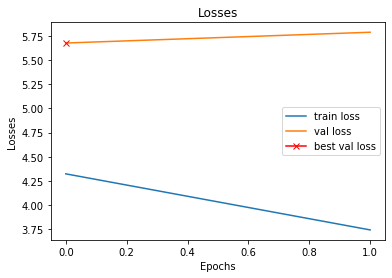

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 3000
Train example :
	Target: a girl underwater in a pool with her eyes closed plugging her nose with one hand .
	Output: a girl in a a pool pool her arms . .
Random example:
	Target: a boy riding on a carnival ride turns around for a photograph .
	Output: a man in a white shirt and white pants is a a in a rodeo .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt and white shorts is a a large blue building .
Train loss    : 3.544283687353134
Val loss      : 5.79963880777359
Val bleur     : 13.272517525080566



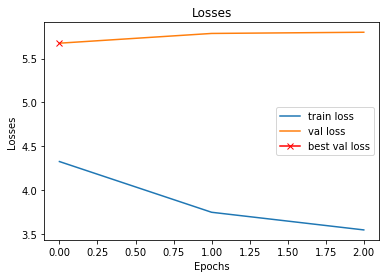

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 4000
Train example :
	Target: an older boy is helping his younger companion down the road .
	Output: a man boy in a a hands boy a a street .
Random example:
	Target: women playing volleyball in the sand near the ocean .
	Output: two women in bathing suits are playing in the water .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt and blue shorts is jumping over a pool .
Train loss    : 3.4383030214309693
Val loss      : 5.927020192146301
Val bleur     : 14.078778622752509



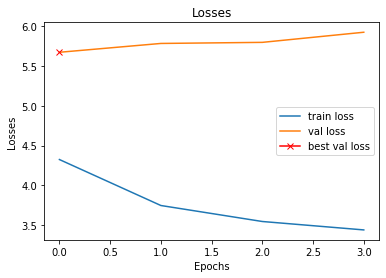

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 5000
Train example :
	Target: a young girl in a sundress and sandals looking at her reflection in a puddle .
	Output: a little girl in a pink and a is at at . .
Random example:
	Target: an elderly man wearing a heavy green coat is selling his goods at his spot on the sidewalk .
	Output: a man in a black coat and a hat is sitting on a bench .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is jumping off a ramp .
Train loss    : 3.36046048784256
Val loss      : 5.768315240740776
Val bleur     : 16.255106632273485



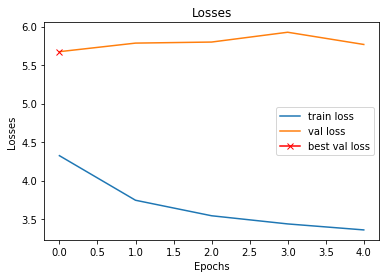

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 6000
Train example :
	Target: a man in a short-sleeve white polo shirt is checking himself out with a woman with short brown hair and a name badge in a library .
	Output: a woman is a black shirt shirt shirt is a a in of a UNK .
Random example:
	Target: a woman with a pink polka dot shirt with green pants standing with one leg forward and one knee back while a woman with a white shirt and black pants watches .
	Output: a young boy in a blue shirt is jumping into a pool .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a red shirt is jumping into the air .
Train loss    : 3.2840744297504427
Val loss      : 5.756888657808304
Val bleur     : 16.176197135597203



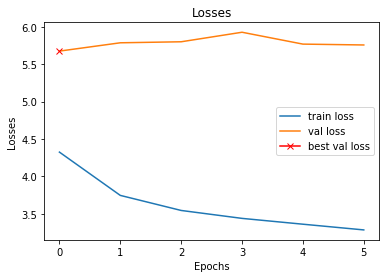

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 7000
Train example :
	Target: older men and women dancing in front of a stage , a man in a white hat twirling a woman in a red flower print skirt and white shirt .
	Output: a people in a are in a of a crowd . while man in a white shirt and a man in a black shirt shirt . and a shirt .
Random example:
	Target: an dark-skinned little boy with headphones in .
	Output: a man in a black shirt and a black shirt is walking down the street .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a yellow shirt is jumping up a ramp .
Train loss    : 3.2379012944698333
Val loss      : 5.7948349714279175
Val bleur     : 16.774756278373175



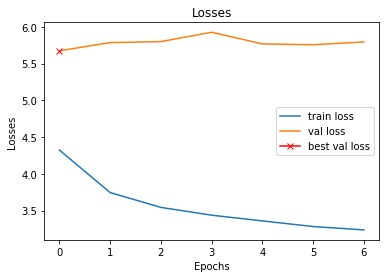

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 8000
Train example :
	Target: a cook slicing some herbs on a wood cutting board .
	Output: a man and food food of a table table board .
Random example:
	Target: a group of people are sitting around a table in a restaurant .
	Output: a group of people are sitting at a restaurant .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt and a shorts is a a man in a blue shirt and a woman in a blue shirt are walking down a street .
Train loss    : 3.199398325920105
Val loss      : 5.842016160488129
Val bleur     : 15.828056905077146



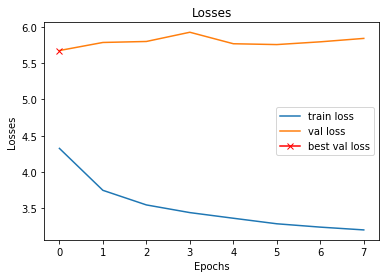

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 9000
Train example :
	Target: the dog retrieves the frisbee is the snow .
	Output: a dog is a ball in standing snow .
Random example:
	Target: three girls are standing together in a room , one is listening , one is writing on a wall and the third is talking to them .
	Output: a woman in a black shirt is standing in front of a store .
Fixed example :
	Target: a group of children learning to swim .
	Output: a young boy in a red shirt is jumping over a railing .
Train loss    : 3.14274326133728
Val loss      : 5.846068128943443
Val bleur     : 17.62832242023889



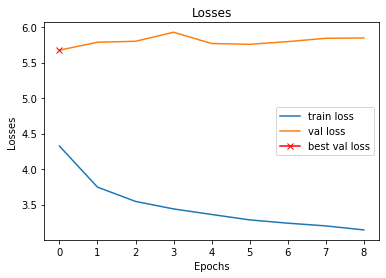

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 10000
Train example :
	Target: a person in a black and red jacket walking up a snowy mountain .
	Output: a man in a red jacket white jacket is on a snowy mountain .
Random example:
	Target: there is a oriental man in a blue jacket walking past spongebob posters .
	Output: a group of people are standing in a bar .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a red shirt and a hat is walking on a sidewalk .
Train loss    : 3.1200602529048918
Val loss      : 5.88113209605217
Val bleur     : 17.06166199390149



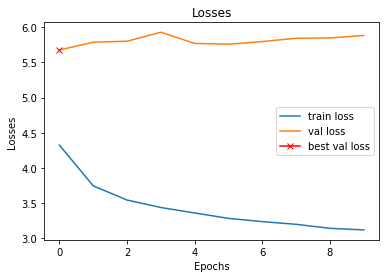

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 11000
Train example :
	Target: three people are having a conversation on a white boat .
	Output: a men are fishing a conversation on a boat boat .
Random example:
	Target: the black dog is climbing on a rock .
	Output: a black dog is standing on a hind legs .
Fixed example :
	Target: swimming UNK teaching young girls how to float in a pool .
	Output: a man in a blue shirt is walking on a sidewalk .
Train loss    : 3.086752906084061
Val loss      : 5.806043371558189
Val bleur     : 18.290558849562537



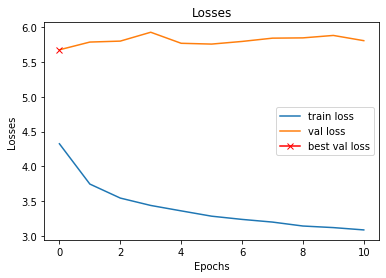

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 12000
Train example :
	Target: girls and boys playing around .
	Output: a are children playing with a
Random example:
	Target: a police officer is directing traffic on a cloudy day .
	Output: a man is a a city street .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt is jumping over a pole .
Train loss    : 3.0650666003227234
Val loss      : 5.783315449953079
Val bleur     : 16.656994962869764



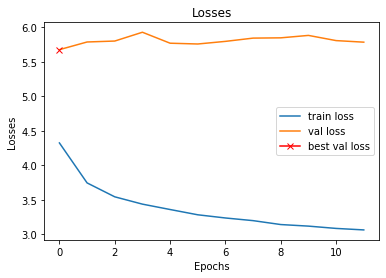

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 13000
Train example :
	Target: four women walk down a snow covered road .
	Output: a people are walking through snow covered snow .
Random example:
	Target: man walking down the sidewalk in front of a pizza shop .
	Output: a man in a blue shirt and blue jeans is walking on a sidewalk .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a blue shirt is doing a trick on a skateboard .
Train loss    : 3.0051011097431184
Val loss      : 5.974010303616524
Val bleur     : 16.95607438345855



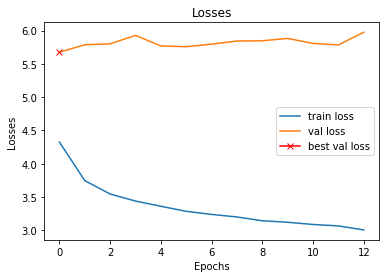

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 14000
Train example :
	Target: people are crowded together on a street .
	Output: a group of street with a busy .
Random example:
	Target: asian women sitting around enjoying themselves .
	Output: a man and a woman are sitting on a bench .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man is a blue shirt is a a man in a blue shirt and a shorts is on a skateboard .
Train loss    : 3.0117553126811982
Val loss      : 5.795013129711151
Val bleur     : 17.800491917547852



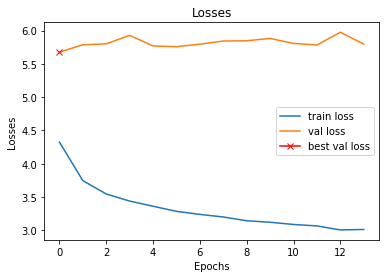

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 15000
Train example :
	Target: a woman in a blue outfit playing tennis .
	Output: a woman in a red tennis is tennis .
Random example:
	Target: a group of palestinian protesters .
	Output: a group of people are standing in a street .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man is a a boat in a pool .
Train loss    : 2.9679503026008605
Val loss      : 5.840627416968346
Val bleur     : 17.40649681264212



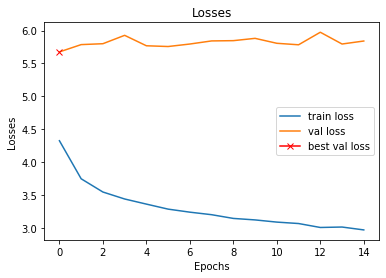

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 16000
Train example :
	Target: a boy climbing through branches .
	Output: a little in a a jungle
Random example:
	Target: the child holds up a big camera to take a photo .
	Output: a man with a camera camera and a camera camera .
Fixed example :
	Target: two men in wetsuits UNK children as they learn to swim .
	Output: a man in a blue shirt and black pants is jumping over a wall .
Train loss    : 2.9484834122657775
Val loss      : 5.886047139763832
Val bleur     : 16.38272279065115



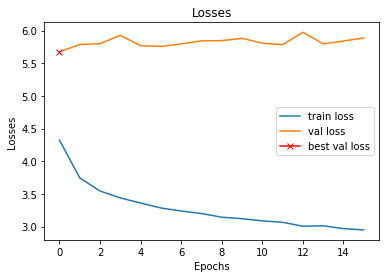

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 17000
Train example :
	Target: picture of a hotdog vendor in the street .
	Output: a of a woman vendor selling fruit product vendor
Random example:
	Target: two nurses are looking at a cart of supplies .
	Output: a woman in a pink shirt is a young girl in a pink shirt .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a yellow shirt and a hat is painting a wall .
Train loss    : 2.9144603452682496
Val loss      : 5.870318502187729
Val bleur     : 16.679195966290898



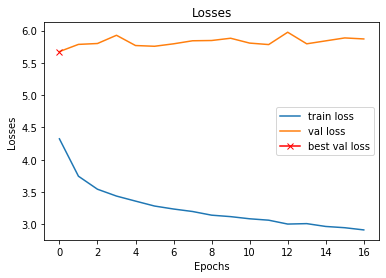

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 18000
Train example :
	Target: a man in a black shirt UNK dough in a white tub .
	Output: a man is a blue shirt is dough in a kitchen tub .
Random example:
	Target: a man touches his UNK with his left hand while looking into the camera .
	Output: a man with a blue shirt is holding a beer bottle .
Fixed example :
	Target: swimming UNK show young girls how to float .
	Output: a man in a blue shirt is skateboarding on a ramp .
Train loss    : 2.9129354310035707
Val loss      : 5.93511463701725
Val bleur     : 16.6896933919339



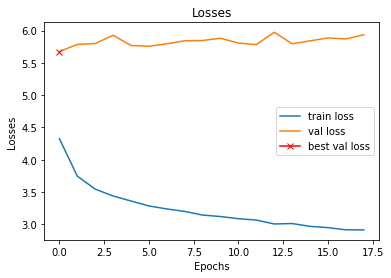

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 19000
Train example :
	Target: a man in blue with a black hat with a dog leaping at him in a park-like setting .
	Output: a man in a jeans a dog dog in a dog in the a . a field area .
Random example:
	Target: two young girls in a street .
	Output: a group of young boys are in a karate match .
Fixed example :
	Target: a group of children learning to swim .
	Output: a man in a yellow shirt is a a wall .
Train loss    : 2.89588024020195
Val loss      : 5.840574637055397
Val bleur     : 18.159918609547393



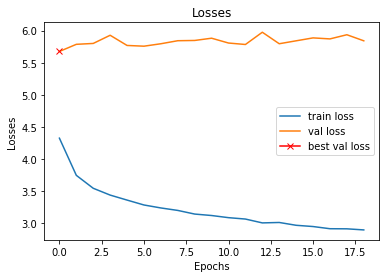

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch : 20000
Train example :
	Target: a man in a neon green and orange vest stands in a crowd behind a woman with brown hair and glasses .
	Output: a man in a blue shirt and a vest is in a crowd . a man in a hair . a blue
Random example:
	Target: a child looking through a telescope on a playground .
	Output: a young boy in a red shirt is sitting on a red .
Fixed example :
	Target: man in black swimsuit plays in pool with three young children .
	Output: a man in a blue shirt and a woman in a white shirt are sitting on a bench in a pool .
Train loss    : 2.8668417229652405
Val loss      : 5.951514706015587
Val bleur     : 16.893025402196862



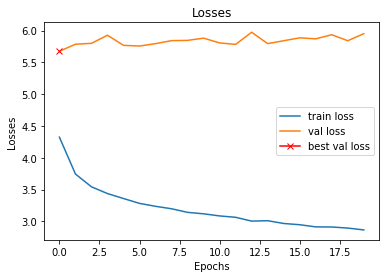

CPU times: user 6h 55min 2s, sys: 19min 14s, total: 7h 14min 17s
Wall time: 7h 3min 51s


In [0]:
%%time
best_bleu = 0
epoch_loss = 0
train_losses = []
val_losses = []
tf = 0.8

for epoch in range(1, max_epochs+1):

  image_vectors, captions_ix = generate_batch(train_dataset, batch_size)
  image_vectors, captions_ix = image_vectors.to(device), captions_ix.to(device)

  captions_ix_next = captions_ix[:, 1:].contiguous()

  network.train()
  network.encoder.eval()

  optimizer.zero_grad()
        
  outputs, atts = network(image_vectors, captions_ix, teacher_forcing_ratio=tf)
 
  loss = criterion(outputs.contiguous().view(-1, outputs.shape[-1]), captions_ix_next.view(-1))
        
  loss.backward()
        
  torch.nn.utils.clip_grad_norm_(network.parameters(), clip)
        
  optimizer.step()
        
  epoch_loss += loss.item()

  if epoch % every_epochs == 0:
    print('Epoch : {}'.format(epoch))
    print('Train example :')
    print('\tTarget: {}'.format(translate(captions_ix_next[0].tolist())))
    print('\tOutput: {}'.format(translate(outputs.argmax(-1)[0].tolist())))
    val_loss, val_bleu = evaluate(network, criterion)   
    print('Train loss    : {}'.format(epoch_loss / every_epochs))
    print('Val loss      : {}'.format(val_loss))
    print('Val bleu      : {}'.format(val_bleu))
    print()
    train_losses.append(epoch_loss / every_epochs)
    val_losses.append(val_loss)
    if val_bleu > best_bleu:
      best_bleu = val_bleu
      torch.save(network.state_dict(), '/content/drive/My Drive/Image Captioning/Flickr30/v3_model_best_bleu.pt')
    epoch_loss = 0
    plt.title("Losses")
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.plot(np.argmin(val_losses), np.min(val_losses), marker="x", color="r", label="best val loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend()
    plt.show()

In [0]:
# torch.save(network.state_dict(), '/content/drive/My Drive/Image Captioning/Flickr30/1/v3_model_20_epoch.pt')

# Проверим качество полученной модели

In [0]:
import skimage.transform
import matplotlib.cm as cm

In [0]:
# Визуализация attention
def visualize_att(image_path, seq, atts, smooth=True):

    image = Image.open(image_path)
    image = image.resize([8 * 24, 8 * 24], Image.LANCZOS)

    words = seq.split() 

    plt.figure(figsize=(10, np.ceil(len(words) / 5.) * 2))
    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_att = atts[t, :].reshape(8, 8)
        if smooth:
            att = skimage.transform.pyramid_expand(current_att, upscale=24, sigma=8)
        else:
            att = skimage.transform.resize(current_att, [8 * 24, 8 * 24])

        plt.imshow(att, alpha=0.75)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

## Модель с best BLEU

In [78]:
network.load_state_dict(torch.load('/content/drive/My Drive/Image Captioning/Flickr30/v3_model_best_bleu.pt')) 

<All keys matched successfully>

In [0]:
network.eval()
network = network.to(device)

Протестируем сначала на примерах из валидационного датасета:

In [0]:
# Fixed example
num_img = 992

[' swimming instructors teaching young girls how to float in a pool .'
 ' man in black swimsuit plays in pool with three young children .'
 ' two men in wetsuits supervise children as they learn to swim .'
 ' swimming instructors show young girls how to float .'
 ' a group of children learning to swim .']


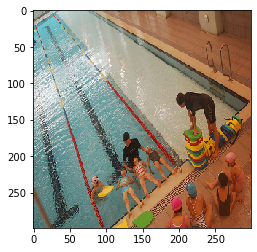

In [92]:
val_dataset.show_sample(num_img)

In [0]:
img, cap = val_dataset[num_img]

In [0]:
image_path = os.path.join(val_dataset.root_dir,
                                val_dataset.data_frame.image_name[num_img])

In [0]:
img = torch.tensor(img, dtype=torch.float32)

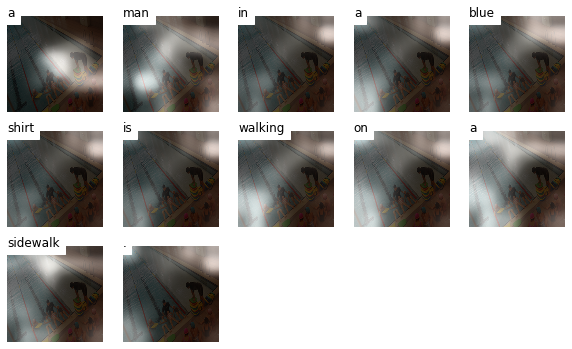

In [96]:
seq, att = network.sample(img.unsqueeze(0).to(device), sample=False)
visualize_att(image_path, seq, att, smooth=True)

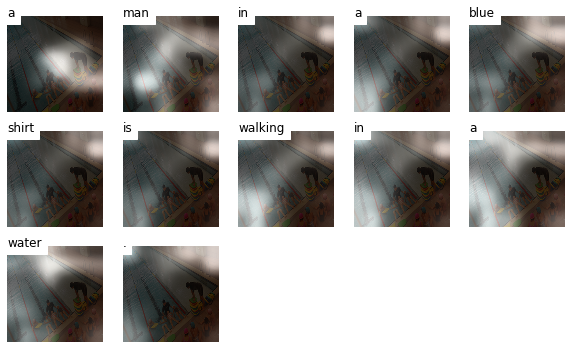

In [107]:
seq, att = network.sample(img.unsqueeze(0).to(device), st=4)
visualize_att(image_path, seq, att, smooth=True)

А теперь несколько случайных примеров:

In [0]:
num_img = random.randint(0, len(val_dataset))

In [109]:
num_img

941

[' a football player from the sooners is about to be taken down by the opposing team in a game .'
 ' the football player is running with the ball as a player of the opposing team grabs his leg'
 ' the sooner football player carrying the ball is trying to avoid being tackled .'
 ' an sooners football player eluding the tackle of two huskies defenders .'
 ' a football player tries tackling another player who has the ball .']


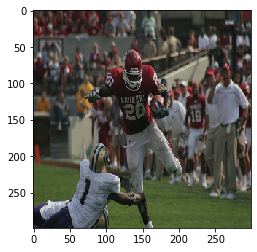

In [110]:
val_dataset.show_sample(num_img)

In [0]:
img, cap = val_dataset[num_img]

In [0]:
image_path = os.path.join(val_dataset.root_dir,
                                val_dataset.data_frame.image_name[num_img])

In [0]:
img = torch.tensor(img, dtype=torch.float32)

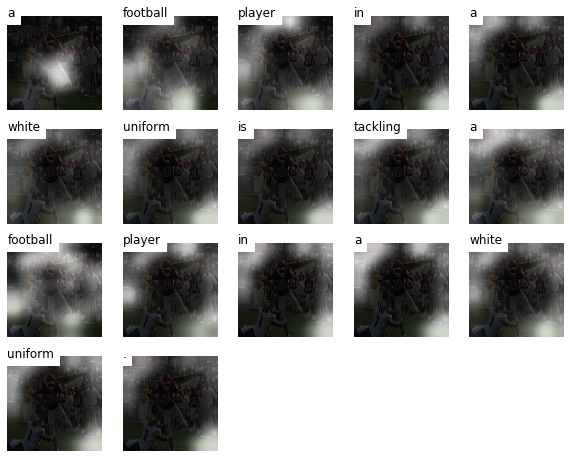

In [114]:
seq, att = network.sample(img.unsqueeze(0).to(device), st=3)
visualize_att(image_path, seq, att, smooth=True)

In [0]:
num_img = random.randint(0, len(val_dataset))

In [117]:
num_img

701

[' a shirtless man wearing blue jean shorts is leaning against a black pole .'
 ' a well built young man standing against a lamp post shirtless .'
 ' a balding shirtless guy stand against a pole in a park .'
 ' shirtless man leaning against black post .'
 ' a man enjoys the sun in a park .']


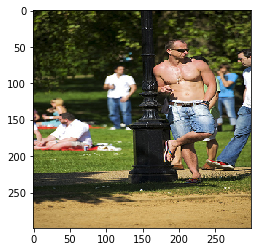

In [118]:
val_dataset.show_sample(num_img)

In [0]:
img, cap = val_dataset[num_img]

In [0]:
image_path = os.path.join(val_dataset.root_dir,
                                val_dataset.data_frame.image_name[num_img])

In [0]:
img = torch.tensor(img, dtype=torch.float32)

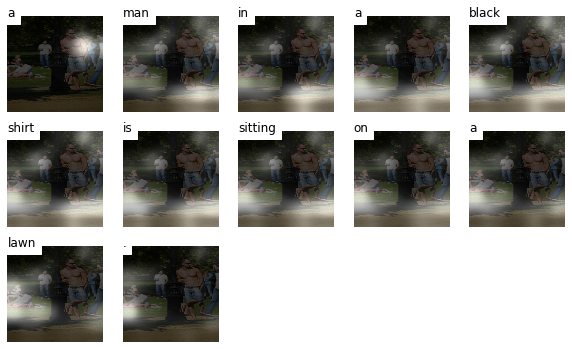

In [128]:
seq, att = network.sample(img.unsqueeze(0).to(device), st=3)
visualize_att(image_path, seq, att, smooth=True)

In [0]:
num_img = random.randint(0, len(val_dataset))

In [142]:
num_img

725

[' a police officer is talking with the driver of the pale yellow car while three other officers stand nearby .'
 ' four policemen standing next to a tan car , one of which is speaking with the driver of said car .'
 ' several police officers standing near a vintage citroen car .'
 ' european police speak with a man driving a citroen .'
 ' a police officer is talking to a man in a car .']


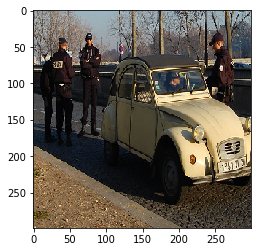

In [143]:
val_dataset.show_sample(num_img)

In [0]:
img, cap = val_dataset[num_img]

In [0]:
image_path = os.path.join(val_dataset.root_dir,
                                val_dataset.data_frame.image_name[num_img])

In [0]:
img = torch.tensor(img, dtype=torch.float32)

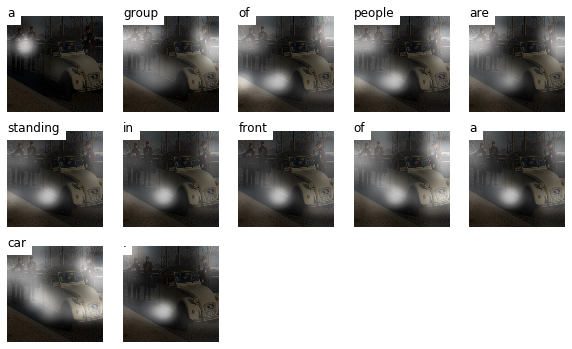

In [150]:
seq, att = network.sample(img.unsqueeze(0).to(device), st=5)
visualize_att(image_path, seq, att, smooth=True)

Теперь скачаем произвольные картинки (не из нашего датасета):

2020-02-23 10:44:08 URL:https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg [107928/107928] -> "img.jpg" [1]


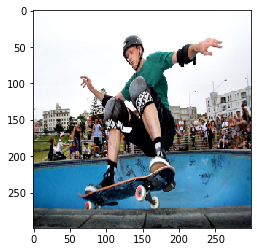

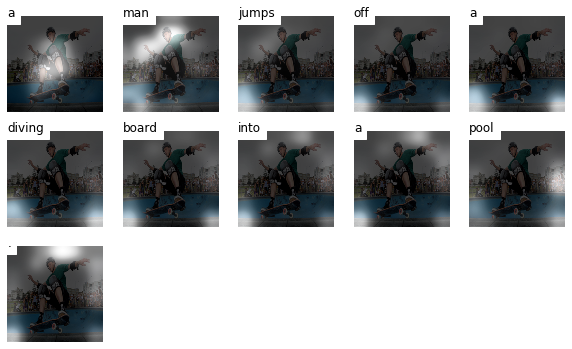

In [87]:
!wget -nv https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32).unsqueeze(0).to(device)
# img = image_transform(img).unsqueeze(0).to(device)

seq, att = network.sample(img, sample=False)
visualize_att('img.jpg', seq, att, smooth=True)

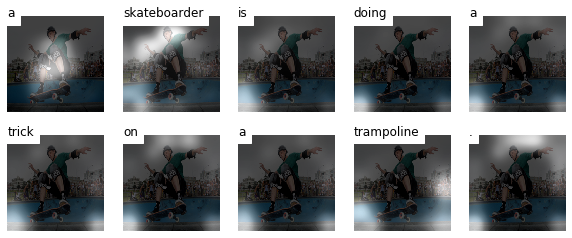

In [86]:
seq, att = network.sample(img, st=5)
visualize_att('img.jpg', seq, att, smooth=True)

2020-02-23 11:14:03 URL:https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [106870/106870] -> "img.jpg" [1]


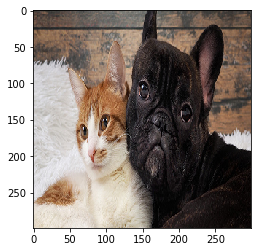

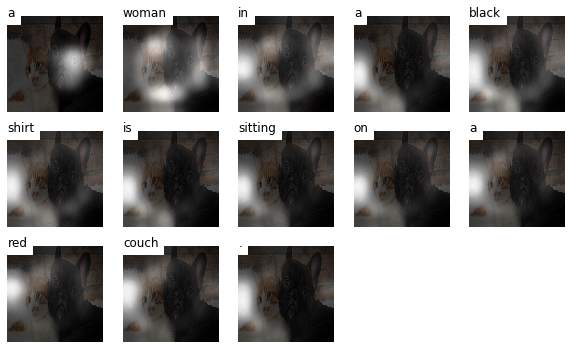

In [158]:
!wget -nv http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32).unsqueeze(0).to(device)
# img = image_transform(img).unsqueeze(0).to(device)

seq, att = network.sample(img, sample=False)
visualize_att('img.jpg', seq, att, smooth=True)

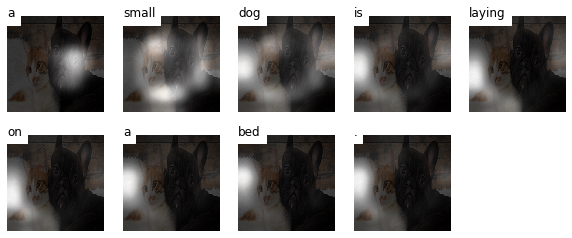

In [170]:
seq, att = network.sample(img, st=3)
visualize_att('img.jpg', seq, att, smooth=True)

2020-02-23 11:20:06 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcReseHyoffy4WlXRV7odBq0ZLxmNdgvxlvs4f1mv1ZV5jm7JRC6 [8560/8560] -> "img.jpg" [1]


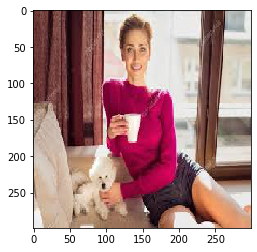

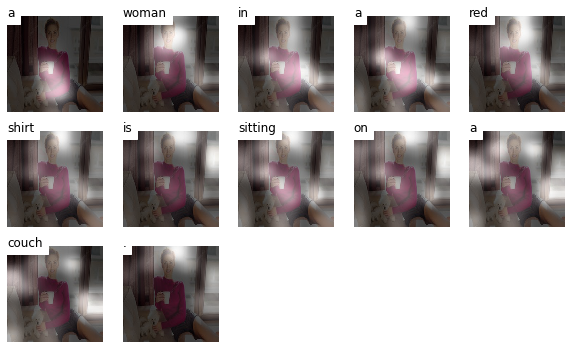

In [179]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcReseHyoffy4WlXRV7odBq0ZLxmNdgvxlvs4f1mv1ZV5jm7JRC6 -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32).unsqueeze(0).to(device)
# img = image_transform(img).unsqueeze(0).to(device)

seq, att = network.sample(img, sample=False)
visualize_att('img.jpg', seq, att, smooth=True)

2020-02-23 11:23:56 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTsDlSPHluolntOWcD-Fjlvjk4pv-_54p4hajvCg29rnNyY5LFX [8192/8192] -> "img.jpg" [1]


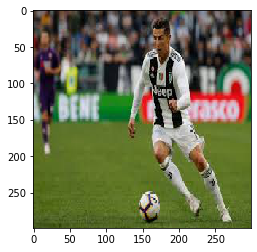

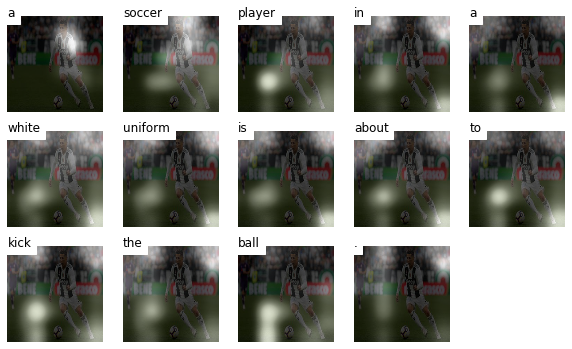

In [190]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTsDlSPHluolntOWcD-Fjlvjk4pv-_54p4hajvCg29rnNyY5LFX -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32).unsqueeze(0).to(device)
# img = image_transform(img).unsqueeze(0).to(device)

seq, att = network.sample(img, sample=False)
visualize_att('img.jpg', seq, att, smooth=True)

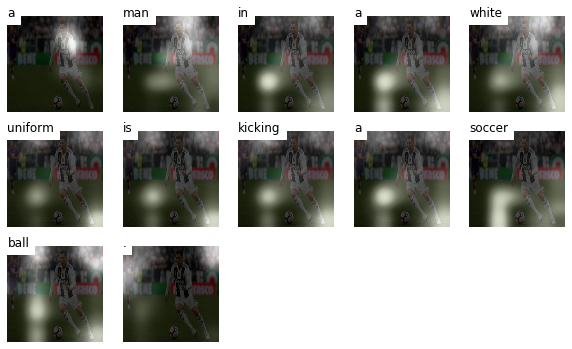

In [188]:
seq, att = network.sample(img, st=3)
visualize_att('img.jpg', seq, att, smooth=True)

2020-02-23 12:38:33 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRLy3gwG_Oz7rVPRnTaWsmCNoI-Lpj86KEQCW1ag02fRwrBMA0Z [5331/5331] -> "img.jpg" [1]


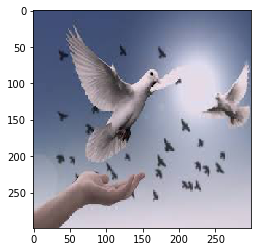

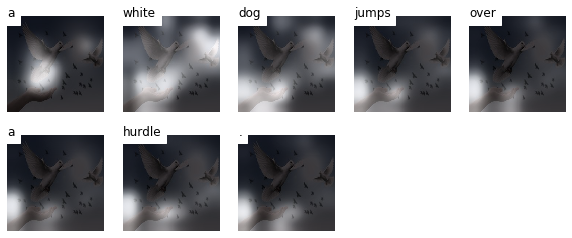

In [238]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRLy3gwG_Oz7rVPRnTaWsmCNoI-Lpj86KEQCW1ag02fRwrBMA0Z -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32).unsqueeze(0).to(device)
# img = image_transform(img).unsqueeze(0).to(device)

seq, att = network.sample(img, sample=False)
visualize_att('img.jpg', seq, att, smooth=True)

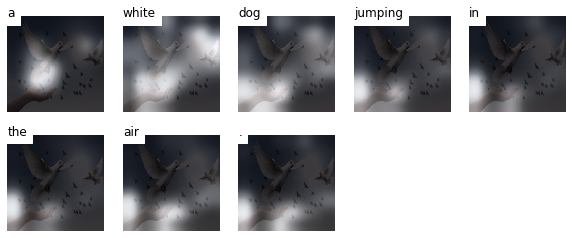

In [239]:
seq, att = network.sample(img, st=3)
visualize_att('img.jpg', seq, att, smooth=True)

2020-02-23 12:32:10 URL:https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT50JLrar0jIMcl1A3MeTJiMRj0SBJAflY4l2Qx9hZR1U_tw8jK [9963/9963] -> "img.jpg" [1]


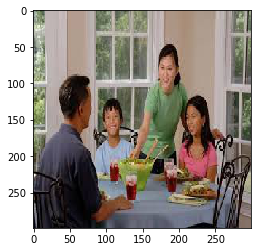

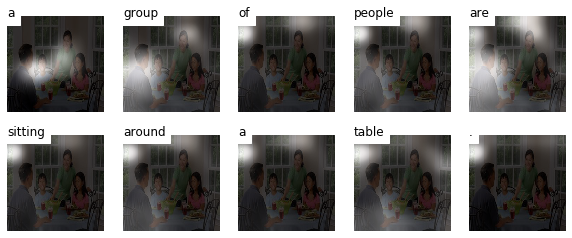

In [225]:
!wget -nv https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT50JLrar0jIMcl1A3MeTJiMRj0SBJAflY4l2Qx9hZR1U_tw8jK -O img.jpg
img = plt.imread('img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299))).astype('float32') / 255.
plt.imshow(img)
plt.show()
img = torch.tensor(img.transpose([2, 0, 1]), dtype=torch.float32).unsqueeze(0).to(device)
# img = image_transform(img).unsqueeze(0).to(device)

seq, att = network.sample(img, sample=False)
visualize_att('img.jpg', seq, att, smooth=True)

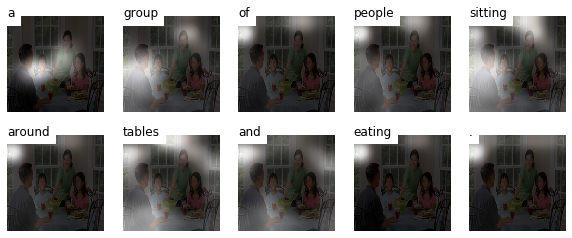

In [237]:
seq, att = network.sample(img, st=2)
visualize_att('img.jpg', seq, att, smooth=True)